# Generating ~~bums~~ people with a deep convolutional GAN

In [1]:
import torch
import torch.nn as nn
from torch.optim import AdamW

from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as tt
from torchsummary import summary

import timm
from accelerate import Accelerator

import albumentations as A
from albumentations.pytorch import ToTensorV2

from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import LeaveOneOut
from sklearn.manifold import TSNE

import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from IPython.display import clear_output
%matplotlib inline

In [2]:
accelerator = Accelerator()
DEVICE = accelerator.device
print("The notebook will be running on", DEVICE, "device")

The notebook will be running on cuda device


In [3]:
RANDOM_STATE = 177013
torch.manual_seed(RANDOM_STATE)
torch.cuda.manual_seed(RANDOM_STATE)
np.random.seed(RANDOM_STATE)

IMAGE_SIZE = 128
BATCH_SIZE = 16
LATENT_SIZE = 128

torch.backends.cudnn.benchmark = True
torch.backends.cudnn.deterministic = True

## Data preparation

We'll be using a part of [Flickr Faces](https://www.kaggle.com/datasets/greatgamedota/ffhq-face-data-set) dataset (70k 128x128 images).

In [4]:
class Transforms:
    def __init__(self, sequence):
        self.transforms = sequence

    def __call__(self, img, *args, **kwargs):
        return self.transforms(image=np.array(img))['image']

transformations = Transforms(A.Compose([
    A.Rotate(3),
    A.HorizontalFlip(p=0.5),
    #A.ColorJitter(), # uncomment to enable fantasy races
    A.GaussNoise(),
    A.Normalize(mean=(0.5), std=(0.5)),
    ToTensorV2(),
]))

In [5]:
dataset = ImageFolder('/media/storage/datasets/faces/', transform=transformations)

In [6]:
def get_dataloader(image_size=IMAGE_SIZE, batch_size=BATCH_SIZE):
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=12, pin_memory=True)
    dataloader = accelerator.prepare(dataloader)
    return dataloader

In [7]:
train_loader = get_dataloader()

## Modeling

Discriminator: just a classifier, accepts an image tensor (`3 x image_size x image_size`), returns the score of an image being genuine (size 1).

Generator: accepts a noise tensor (`latent_size x 1 x 1`) and returns a fake image tensor (`3 x image_size x image_size`).

In [9]:
class Discriminator(nn.Module):
    def conv_block(self, in_channels, out_channels, padding=1):
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 4, 2, padding=padding, padding_mode='reflect', bias=False),
            nn.InstanceNorm2d(out_channels),
            nn.SiLU(inplace=True),
        )
        return self.conv
    def __init__(self, n_features=LATENT_SIZE):
        super().__init__()
        self.net = nn.Sequential(
            self.conv_block(3, n_features),
            self.conv_block(n_features, n_features * 2),
            self.conv_block(n_features * 2, n_features * 4),
            self.conv_block(n_features * 4, n_features * 8),
            self.conv_block(n_features * 8, n_features * 16),
            nn.Conv2d(n_features * 16, 1, kernel_size=4, stride=2, padding=0),
            #nn.Sigmoid(),
        )
    def forward(self, x):
        return self.net(x)

In [10]:
summary(Discriminator().to(DEVICE), (3,128,128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 128, 64, 64]           6,144
    InstanceNorm2d-2          [-1, 128, 64, 64]               0
              SiLU-3          [-1, 128, 64, 64]               0
            Conv2d-4          [-1, 256, 32, 32]         524,288
    InstanceNorm2d-5          [-1, 256, 32, 32]               0
              SiLU-6          [-1, 256, 32, 32]               0
            Conv2d-7          [-1, 512, 16, 16]       2,097,152
    InstanceNorm2d-8          [-1, 512, 16, 16]               0
              SiLU-9          [-1, 512, 16, 16]               0
           Conv2d-10           [-1, 1024, 8, 8]       8,388,608
   InstanceNorm2d-11           [-1, 1024, 8, 8]               0
             SiLU-12           [-1, 1024, 8, 8]               0
           Conv2d-13           [-1, 2048, 4, 4]      33,554,432
           Conv2d-14           [-1, 204

In [11]:
class PixelNorm(nn.Module):
    def __init__(self):
        super().__init__()
        self.epsilon = 1e-8
    def forward(self, x):
        return x / torch.sqrt(torch.mean(x ** 2, dim=1, keepdim=True) + self.epsilon)

In [12]:
class Generator(nn.Module):
    def upconv_block(self, in_channels, out_channels, padding=1):
        self.conv = nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, 4, 2, padding=padding, bias=False),
            PixelNorm(),
            nn.SiLU(inplace=True),
        )
        return self.conv
    def __init__(self, latent_size=LATENT_SIZE):
        super().__init__()
        self.net = nn.Sequential(
            self.upconv_block(LATENT_SIZE, latent_size * 16, padding=0),
            self.upconv_block(latent_size * 16, latent_size * 8),
            self.upconv_block(latent_size * 8, latent_size * 4),
            self.upconv_block(latent_size * 4, latent_size * 2),
            self.upconv_block(latent_size * 2, latent_size * 1),
            nn.ConvTranspose2d(latent_size, 3, kernel_size=4, stride=2, padding=1),
            nn.Tanh(),
        )
        
    def forward(self, x):
        return self.net(x)

In [13]:
summary(Generator().to(DEVICE), (LATENT_SIZE,1,1))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ConvTranspose2d-1           [-1, 2048, 4, 4]       4,194,304
         PixelNorm-2           [-1, 2048, 4, 4]               0
              SiLU-3           [-1, 2048, 4, 4]               0
   ConvTranspose2d-4           [-1, 1024, 8, 8]      33,554,432
         PixelNorm-5           [-1, 1024, 8, 8]               0
              SiLU-6           [-1, 1024, 8, 8]               0
   ConvTranspose2d-7          [-1, 512, 16, 16]       8,388,608
         PixelNorm-8          [-1, 512, 16, 16]               0
              SiLU-9          [-1, 512, 16, 16]               0
  ConvTranspose2d-10          [-1, 256, 32, 32]       2,097,152
        PixelNorm-11          [-1, 256, 32, 32]               0
             SiLU-12          [-1, 256, 32, 32]               0
  ConvTranspose2d-13          [-1, 128, 64, 64]         524,288
  ConvTranspose2d-14          [-1, 128,

In [14]:
# Using a premade classifier is possible but not recommended, this makes traction extremely fragile.
# discriminator = timm.create_model('resnet18d', pretrained=False, num_classes=2)
discriminator = Discriminator()
generator = Generator()

In [15]:
class MyGAN:
    def __init__(self, discriminator, generator, lr=3e-4):
        disc_optim = AdamW(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
        gen_optim = AdamW(generator.parameters(), lr=lr, betas=(0.5, 0.999))
        
        self.discriminator, self.generator, self.disc_optim, self.gen_optim = accelerator.prepare(
                                                                                                    discriminator,
                                                                                                    generator,
                                                                                                    disc_optim,
                                                                                                    gen_optim,
                                                                                                 )
        self.criterion = nn.BCEWithLogitsLoss()
        
    def train(self, epochs, data_tr):
        # Forward declaration:
        return train_gan(self, epochs, data_tr)

In [16]:
def initialize_weights(model):
    # Initializes weights according to the DCGAN paper
    for m in model.modules():
        if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d, nn.BatchNorm2d)):
            nn.init.normal_(m.weight.data, 0.0, 0.02)

In [17]:
initialize_weights(discriminator)
initialize_weights(generator)

In [18]:
model = MyGAN(discriminator, generator)

In [19]:
class History:
    def __init__(self, name='Unknown'):
        self.disc_loss = []
        self.gen_loss = []
        self.sum_loss = []
        self.name = name
    def add(self, disc_loss, gen_loss):
        self.disc_loss.append(disc_loss)
        self.gen_loss.append(gen_loss)
        self.sum_loss.append(disc_loss + gen_loss)
    def best_epoch(self):
        return np.argmin(np.array(self.sum_loss))
    def display(self):
        fig, ax = plt.subplots(1, 1, figsize=(16, 5))
        ax.set(xlim=(0, len(self.disc_loss)-1), ylim=(0, max(max(self.disc_loss), max(self.gen_loss))), xlabel='Эпоха')
        plt.plot(self.disc_loss);
        plt.plot(self.gen_loss);
        plt.legend(['discriminator loss', 'generator loss']);
        print(f'{self.name}: best loss {min(self.sum_loss):.4f} на {self.best_epoch()+1} эпохе')

In [20]:
picture = lambda t: (t * 0.5 + 0.5).permute(1, 2, 0).cpu().detach().numpy()

In [21]:
def train_gan(model, epochs, data_tr):
    title = f'{type(model).__name__}'
    history = History(title)

    for epoch in range(epochs):
        print('* Epoch %d/%d' % (epoch+1, epochs))

        loss_disc = 0
        loss_gen = 0

        for source, _ in tqdm(data_tr):
            model.discriminator.train()
            model.generator.train()
            # Generating a fake image:
            fake = model.generator(torch.randn((BATCH_SIZE, LATENT_SIZE, 1, 1), device=DEVICE))
            # Test the discriminator against real and fake images:
            estimation_real = model.discriminator(source)
            estimation_fake = discriminator(fake.detach())
            real_loss = model.criterion(estimation_real, torch.ones_like(estimation_real))
            fake_loss = model.criterion(estimation_fake, torch.zeros_like(estimation_fake))
            # Average loss:    
            disc_loss = (real_loss + fake_loss) / 2.
            model.disc_optim.zero_grad()
            accelerator.backward(disc_loss)
            model.disc_optim.step()
            loss_disc += disc_loss
            
            # Test the generator:
            estimation_fake = model.discriminator(fake)
            gen_loss = model.criterion(estimation_fake, torch.ones_like(estimation_fake))
        
            model.gen_optim.zero_grad()
            accelerator.backward(gen_loss)
            model.gen_optim.step()
            loss_gen += gen_loss
            
        loss_disc /= len(train_loader)
        loss_gen /= len(train_loader)    
        history.add(loss_disc.detach().cpu(), loss_gen.detach().cpu())
        print(f'Epoch {epoch}: disc loss {loss_disc}, gen loss {loss_gen:.2f}')            

        model.discriminator.eval()
        model.generator.eval()

        if epoch == history.best_epoch():
            torch.save(model.discriminator.state_dict(), f'{title}-disc.pt')
            torch.save(model.generator.state_dict(), f'{title}-gen.pt')
    
        clear_output(wait=True)
        for k in range(5):
            plt.subplot(3, 5, k+1)
            plt.imshow(picture(source[k]))
            plt.title('Real')
            plt.axis('off')

            plt.subplot(3, 5, k+6)
            plt.imshow(picture(fake[k]))
            plt.title('Output')
            plt.axis('off')
            
        plt.suptitle(f'Epoch {epoch+1}/{epochs}: disc loss {loss_disc:.2E}, gen loss {loss_gen:.2f}')
        plt.show()
    torch.cuda.empty_cache()
    # Do not load - the loss sum may diverge.
    #model.discriminator.load_state_dict(torch.load(f'{title}-disc.pt'))
    #model.generator.load_state_dict(torch.load(f'{title}-gen.pt'))
    model.discriminator.eval()
    model.generator.eval()
    return history

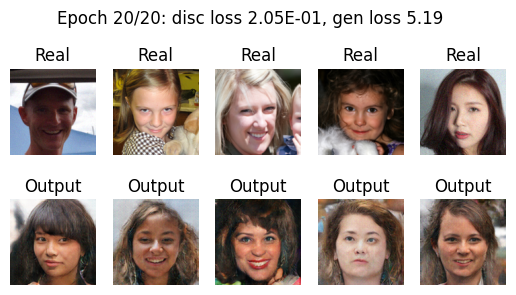

In [22]:
history = model.train(20, train_loader)

MyGAN: наилучший loss 3.5470 на 3 эпохе


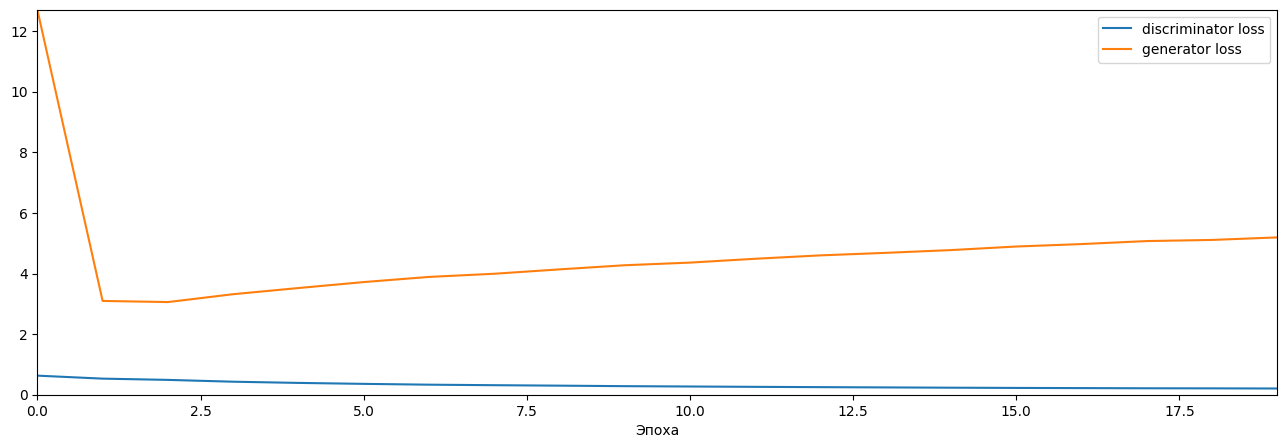

In [23]:
history.display()

## Generating images

In [24]:
def show_images(generated):
    side = int(n_images ** 0.5)
    fig, axes = plt.subplots(side, side, figsize=(12,6))
    for i, ax in enumerate(axes.flat):
        ax.axis("off")
        ax.imshow(picture(generated[i]))

In [25]:
n_images = 16

with torch.no_grad():
    fixed_latent = torch.randn((n_images, LATENT_SIZE, 1, 1), device=DEVICE)
    fake_images = model.generator(fixed_latent)

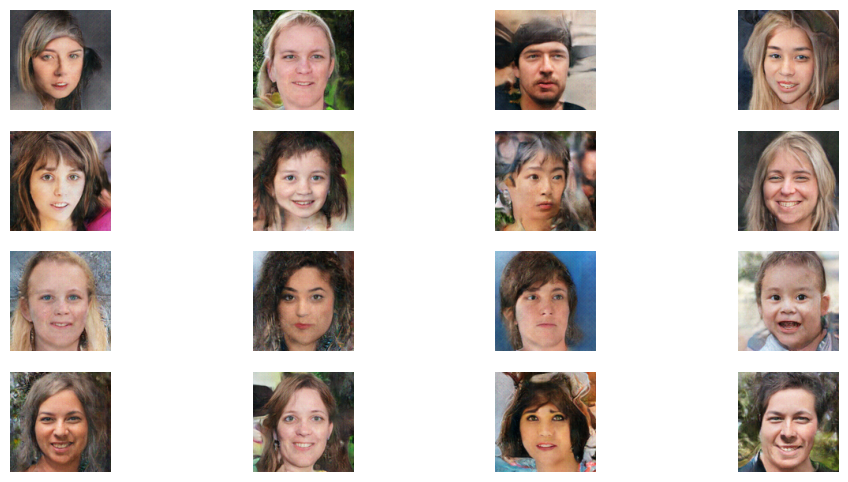

In [26]:
show_images(fake_images)